# Step 1: Imports and Data Loading

In [1]:
import pandas as pd
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configuration ---
DATA_DIR = Path("../output")
MODEL_DATA_FILE = DATA_DIR / "readmissions_dataset.parquet"

# --- Load the Dataset ---
print(f"Loading dataset from {MODEL_DATA_FILE}...")
df = pd.read_parquet(MODEL_DATA_FILE)

print("Dataset loaded successfully.")
df.head()

Loading dataset from ../output/readmissions_dataset.parquet...
Dataset loaded successfully.


,encounter_id,patient_id,readmitted_within_30_days,length_of_stay,age_at_admission,gender,race,marital_status,admission_reason,admission_reason_detail,...,total_claim_cost,income,admission_day_of_week,primary_diagnosis_code,provider_id,payer_dx_interaction,prior_admissions_last_year,num_diagnoses,num_procedures,num_medications
0,fd70210f-52cb-77ef-61c7-aadbd1018a99,e3d3ed64-ca29-b95b-dbba-abfa3ee61b44,0,1,69,male,White,D,Hospital admission (procedure),Acute non-ST segment elevation myocardial infa...,...,40610.128906,33853,Sunday,401314000,us-npi|9999868992,Medicare_401314000,0,1.0,0.0,4.0
1,f2fa6d45-a393-6aea-83d4-166fbaa0a4a9,34270d54-36d4-f26b-4e4d-0cdb327cf159,1,1,57,male,White,D,Hospital admission (procedure),Abnormal findings diagnostic imaging heart+cor...,...,37202.929688,30294,Thursday,274531002,us-npi|9999868992,Aetna_274531002,0,1.0,21.0,0.0
2,3c16cdb1-a750-7963-b963-cc0f90e727f1,34270d54-36d4-f26b-4e4d-0cdb327cf159,1,2,57,male,White,D,Patient transfer to intensive care unit (proce...,History of coronary artery bypass grafting (si...,...,15647.690430,30294,Thursday,399261000,us-npi|9999868992,Aetna_399261000,1,0.0,6.0,0.0
3,3fc36a47-cb8f-56a4-3b11-a434126d40ca,34270d54-36d4-f26b-4e4d-0cdb327cf159,0,1,57,male,White,D,Admission to ward (procedure),History of coronary artery bypass grafting (si...,...,2176.229980,30294,Saturday,399261000,us-npi|9999868992,Aetna_399261000,2,0.0,4.0,0.0
4,df4e5b66-ca7f-5b68-a5c2-c77def0a94ce,13aebc7f-8e4a-396d-1666-1af41cb27781,0,13,43,male,White,S,Drug rehabilitation and detoxification (regime...,Dependent drug abuse (disorder),...,119.830002,11631,Monday,6525002,us-npi|9999927293,Anthem_6525002,0,0.0,0.0,0.0


# Step 2: Feature Engineering & Preprocessing

Next, we'll prepare the data for the models. We need to separate our features from the target variable (readmitted_within_30_days). We will also identify which columns are categorical so the models can handle them correctly. Finally, we split the data into training and testing sets.

In [2]:
# Define the target and features
TARGET = 'readmitted_within_30_days'

# Drop identifiers and high-cardinality text fields that might not be useful directly
features_to_drop = ['encounter_id', 'patient_id', 'admission_reason_detail']
X = df.drop(columns=[TARGET] + features_to_drop)
y = df[TARGET]

# Identify categorical features for the models
categorical_features = [
    'gender', 'race', 'marital_status', 'admission_reason', 
    'payer', 'admission_day_of_week', 'primary_diagnosis_code', 
    'provider_id', 'payer_dx_interaction'
]

# Convert categorical features to the 'category' dtype for efficiency
for col in categorical_features:
    X[col] = X[col].astype('category')

print(f"Target variable: {TARGET}")
print(f"Number of features: {len(X.columns)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Target variable: readmitted_within_30_days
Number of features: 17
Training set shape: (83253, 17)
Test set shape: (20814, 17)


# Step 3: Train LightGBM Model

Now, let's train our first model: LightGBM. It's a fast and efficient gradient-boosting framework. We'll instantiate the classifier and fit it to our training data, telling it which features are categorical.

In [3]:
# Initialize the LightGBM classifier
lgbm = lgb.LGBMClassifier(random_state=42)

# Train the model
print("Training LightGBM model...")
lgbm.fit(X_train, y_train, categorical_feature=categorical_features)

# Make predictions
lgbm_preds = lgbm.predict(X_test)
lgbm_preds_proba = lgbm.predict_proba(X_test)[:, 1]

print("✅ LightGBM training complete.")

Training LightGBM model...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 14827, number of negative: 68426
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2909
[LightGBM] [Info] Number of data points in the train set: 83253, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.178096 -> initscore=-1.529303
[LightGBM] [Info] Start training from score -1.529303
✅ LightGBM training complete.


LightGBM Model Evaluation
Let's see how well it did. We'll check the accuracy, AUC score (which is great for imbalanced datasets), and a full classification report. A confusion matrix will also help us visualize the true vs. predicted labels.

--- LightGBM Performance ---
Accuracy: 0.9163
AUC Score: 0.9498

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     17107
           1       0.91      0.59      0.72      3707

    accuracy                           0.92     20814
   macro avg       0.91      0.79      0.83     20814
weighted avg       0.92      0.92      0.91     20814

Confusion Matrix:


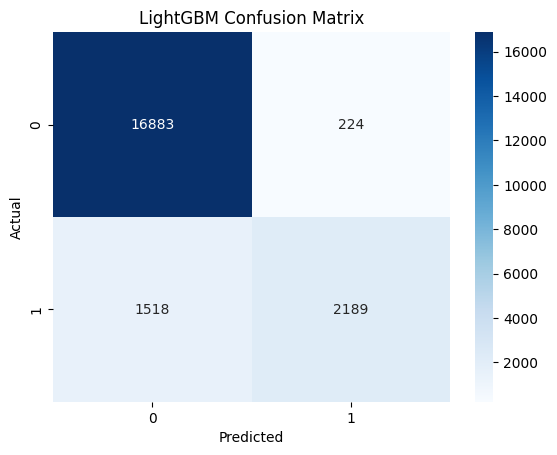

In [4]:
print("--- LightGBM Performance ---")
print(f"Accuracy: {accuracy_score(y_test, lgbm_preds):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, lgbm_preds_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lgbm_preds))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, lgbm_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LightGBM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Step 4: Train CatBoost Model

Next up is CatBoost. This model is particularly powerful when you have a lot of categorical features, as it has built-in, sophisticated methods for handling them. The process is very similar to the one for LightGBM.

In [8]:
# --- Add this preprocessing step ---
print("Preprocessing for CatBoost: Filling NaN in categorical features...")
for col in categorical_features:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')
    
    # Convert back to category dtype after filling
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    
print("Preprocessing complete.")

Preprocessing for CatBoost: Filling NaN in categorical features...
Preprocessing complete.


In [9]:
# --- Your original CatBoost code will now work ---
# Initialize the CatBoost classifier
cat = cb.CatBoostClassifier(random_state=42, verbose=0, cat_features=categorical_features)

# Train the model
print("Training CatBoost model...")
cat.fit(X_train, y_train)

# Make predictions
cat_preds = cat.predict(X_test)
cat_preds_proba = cat.predict_proba(X_test)[:, 1]

print("✅ CatBoost training complete.")

Training CatBoost model...
✅ CatBoost training complete.


CatBoost Model Evaluation
Now we'll evaluate the CatBoost model using the same metrics.

--- CatBoost Performance ---
Accuracy: 0.9182
AUC Score: 0.9528

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     17107
           1       0.92      0.59      0.72      3707

    accuracy                           0.92     20814
   macro avg       0.92      0.79      0.84     20814
weighted avg       0.92      0.92      0.91     20814

Confusion Matrix:


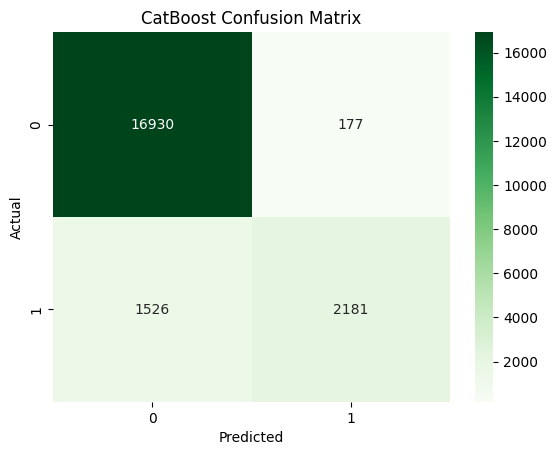

In [10]:
print("--- CatBoost Performance ---")
print(f"Accuracy: {accuracy_score(y_test, cat_preds):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, cat_preds_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, cat_preds))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, cat_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('CatBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Step 5: Model Comparison & Feature Importance

Finally, let's compare the two models side-by-side using their AUC scores and look at which features the better-performing model (CatBoost) found most important. This can give us valuable insights into the key drivers of hospital readmission.

In [13]:
print("--- Model Comparison ---")
print(f"LightGBM AUC: {roc_auc_score(y_test, lgbm_preds_proba):.4f}")
print(f"CatBoost AUC: {roc_auc_score(y_test, cat_preds_proba):.4f}")

# Get feature importances from the better model (or both)
# Let's assume CatBoost performed slightly better and use it for importance
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': cat.get_feature_importance()
}).sort_values('importance', ascending=False)

print("\nFeatures by Importance (from CatBoost):")
display(feature_importance_df)

--- Model Comparison ---
LightGBM AUC: 0.9498
CatBoost AUC: 0.9528

Features by Importance (from CatBoost):


,feature,importance
10,primary_diagnosis_code,25.395558
15,num_procedures,18.684474
5,admission_reason,15.140925
7,total_claim_cost,6.266519
11,provider_id,5.705067
1,age_at_admission,5.387365
13,prior_admissions_last_year,4.027615
14,num_diagnoses,3.675956
8,income,3.117251
12,payer_dx_interaction,2.842714


# Improving Recall

Adjust the Decision Threshold (Easiest & Fastest)

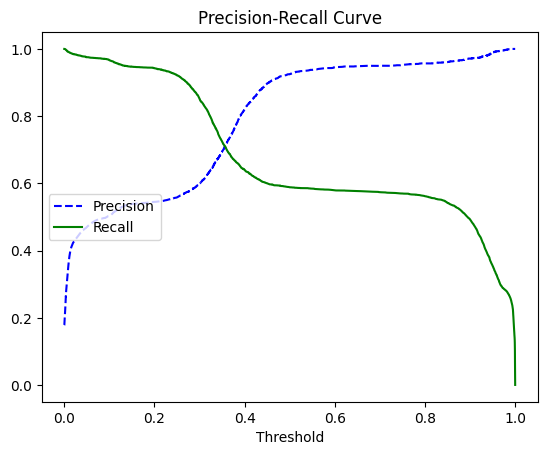

--- Results with new threshold of 0.35 ---
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     17107
           1       0.56      0.92      0.70      3707

    accuracy                           0.86     20814
   macro avg       0.77      0.88      0.80     20814
weighted avg       0.91      0.86      0.87     20814



In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Get prediction probabilities for the positive class
y_probs = cat.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the curve
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='center left')
plt.title('Precision-Recall Curve')
plt.show()

# Example: Set a new threshold and see the result
new_threshold = 0.25
new_preds = (y_probs >= new_threshold).astype(int)

print("--- Results with new threshold of 0.35 ---")
print(classification_report(y_test, new_preds))

Attempt to resolve class imbalance 

In [16]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate the weight
# count of not readmitted / count of readmitted
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Re-initialize and retrain CatBoost with the new parameter
cat_weighted = cb.CatBoostClassifier(
    random_state=42,
    verbose=0,
    cat_features=categorical_features,
    scale_pos_weight=scale_pos_weight  # Add the weight here
)

# Train the model
print("Training weighted CatBoost model...")
cat_weighted.fit(X_train, y_train)

# Evaluate the new model
weighted_preds = cat_weighted.predict(X_test)
print(classification_report(y_test, weighted_preds))

Calculated scale_pos_weight: 4.61
Training weighted CatBoost model...
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     17107
           1       0.55      0.94      0.69      3707

    accuracy                           0.85     20814
   macro avg       0.77      0.89      0.80     20814
weighted avg       0.91      0.85      0.86     20814



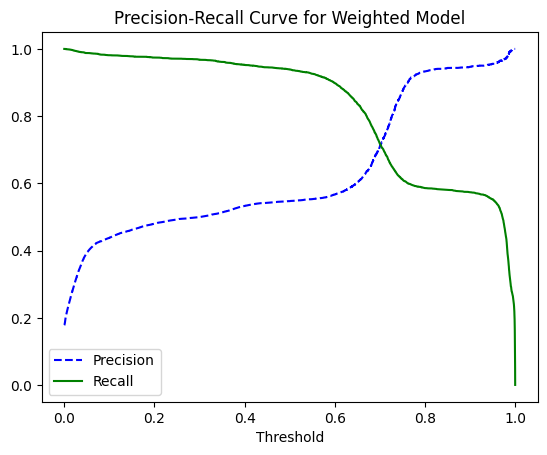

In [17]:
# Use your trained weighted model: cat_weighted
y_probs_weighted = cat_weighted.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_weighted)

# Plot the curve to find a good balance
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.title('Precision-Recall Curve for Weighted Model')
plt.legend()
plt.show()

In [21]:
# CHOOSE YOUR THRESHOLD BASED ON THE PLOT
final_threshold = 0.7

# Apply the threshold to the probabilities from your weighted model
final_predictions = (y_probs_weighted >= final_threshold).astype(int)

# Print the final, tuned classification report
print(f"--- Final Results with Threshold = {final_threshold} ---")
print(classification_report(y_test, final_predictions))

--- Final Results with Threshold = 0.7 ---
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     17107
           1       0.71      0.72      0.71      3707

    accuracy                           0.90     20814
   macro avg       0.82      0.83      0.83     20814
weighted avg       0.90      0.90      0.90     20814

